In [86]:
import warnings
warnings.simplefilter('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
get_ipython().magic('matplotlib inline')

import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import tensorflow as tf
import wfdb

In [100]:
train = pd.read_csv('ECG_Heartbeat_Categorization_Dataset/mitbih_train.csv', header = None)
test = pd.read_csv('ECG_Heartbeat_Categorization_Dataset/mitbih_test.csv', header = None)

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
print(df_train.shape, df_test.shape)

(87554, 188) (21892, 188)


In [101]:
print(df_test.iloc[:,-1].value_counts())
print(df_train.iloc[:,-1].value_counts())

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


In [102]:
# randomly choose 5000 samples from each class
num_of_sample = 5000
sampled_train_0 = df_train[df_train.iloc[:, 187]==0].sample(n=num_of_sample, random_state=42)
sampled_train_1 = df_train[df_train.iloc[:, 187]==1].sample(n=num_of_sample, replace=True, random_state=42)
sampled_train_2 = df_train[df_train.iloc[:, 187]==2].sample(n=num_of_sample, replace=True, random_state=42)
sampled_train_4 = df_train[df_train.iloc[:, 187]==4].sample(n=num_of_sample, replace=True, random_state=42)
sampled_train_3 = df_train[df_train.iloc[:, 187]==3].sample(n=num_of_sample, replace=True, random_state=42)

# concat and shuffle
sampled_df_train = pd.concat([sampled_train_0, sampled_train_1, sampled_train_2, sampled_train_3, sampled_train_4], axis = 0)
df_train = sampled_df_train.sample(frac=1).reset_index(drop=True)

# last column to category
df_train[187] = df_train[187].astype('int').astype('category')
df_train[187]

0        0
1        3
2        2
3        1
4        0
        ..
24995    1
24996    3
24997    0
24998    0
24999    2
Name: 187, Length: 25000, dtype: category
Categories (5, int64): [0, 1, 2, 3, 4]

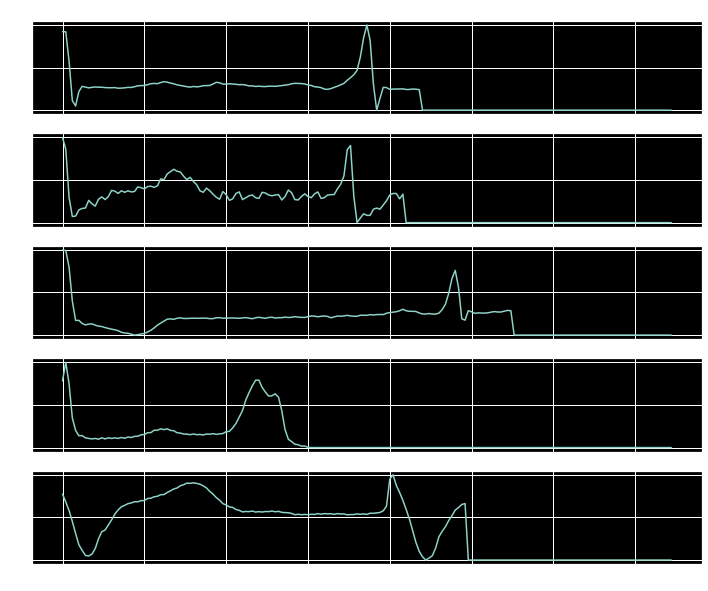

In [8]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(5,1,1)
plt.plot(df_train[df_train.iloc[:,187]==0].sample(n=1).iloc[0,:187])
ax1.set_title("class N")

ax2 = plt.subplot(5,1,2)
plt.plot(df_train[df_train.iloc[:,187]==1].sample(n=1).iloc[0,:187])
ax2.set_title("class S")

ax3 = plt.subplot(5,1,3)
plt.plot(df_train[df_train.iloc[:,187]==2].sample(n=1).iloc[0,:187])
ax3.set_title("class V")

ax4 = plt.subplot(5,1,4)
plt.plot(df_train[df_train.iloc[:,187]==3].sample(n=1).iloc[0,:187])
ax4.set_title("class F")

ax5 = plt.subplot(5,1,5)
plt.plot(df_train[df_train.iloc[:,187]==4].sample(n=1).iloc[0,:187])
ax5.set_title("class Q")

plt.show()

### N
+ Normal
+ Left/Right bundle branch block
+ Atrial escape
+ Nodal escape

### S
+ Atrial premature
+ Aberrant atrial premature
+ Nodal premature
+ Supra-ventricular premature

### V
+ Premature ventricular contraction
+ Ventricular escape

### F
+ Fusion of ventricular and normal

### Q
+ Paced
+ Fusion of paced and normal
+ Unclassifiable

In [122]:
X_train0 = df_train.iloc[:, :187]
y_train0 = df_train.iloc[:, 187]
X_test0 = df_test.iloc[:, :187]
y_test = df_test.iloc[:, 187]
print(X_train0.shape, y_train0.shape, X_test0.shape, y_test.shape)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys
#import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

X_train = np.resize(X_train0, (X_train0.shape[0], 187, 1))
X_test = np.resize(X_test0, (X_test0.shape[0], 187, 1))
print(X_train.shape, X_test.shape)

from tensorflow.keras import utils
y_train = utils.to_categorical(y_train0, 5)
print(y_train.shape, y_train)

(25000, 187) (25000,) (21892, 187) (21892,)
(25000, 187, 1) (21892, 187, 1)
(25000, 5) [[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [104]:
from sklearn.metrics import confusion_matrix

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

### CNN

In [123]:
# CNN model

model_CNN = Sequential()

model_CNN.add(Conv1D(8, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],1)))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Dropout(0.25))
model_CNN.add(Flatten())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(5, activation='softmax'))

model_CNN.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 187, 8)            32        
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 93, 8)             0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 93, 16)            400       
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 46, 16)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 46, 32)            1568      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 23, 64)          

In [124]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

model_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [117]:
history_CNN = model_CNN.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[reduceLR, earlystopping])

Epoch 1/50
313/313 [==============================] - 6s 20ms/step - loss: 0.8744 - accuracy: 0.6780 - val_loss: 0.5205 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - 6s 21ms/step - loss: 0.5162 - accuracy: 0.8087 - val_loss: 0.4088 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - 6s 20ms/step - loss: 0.4235 - accuracy: 0.8400 - val_loss: 0.3445 - val_accuracy: 0.8728 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - 6s 20ms/step - loss: 0.3740 - accuracy: 0.8648 - val_loss: 0.3019 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 5/50
313/313 [==============================] - 6s 18ms/step - loss: 0.3311 - accuracy: 0.8758 - val_loss: 0.2931 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 6/50
313/313 [==============================] - 6s 18ms/step - loss: 0.3054 - accuracy: 0.8885 - val_loss: 0.2492 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 7/50
313/313 [==============================] - 5s 17ms/st

In [118]:
y_pred0 = model_CNN.predict(X_test)

In [119]:
y_pred = []
for i in range(y_pred0.shape[0]):
    y_pred.append(y_pred0[i].argmax())

Accuracy: 94.64%


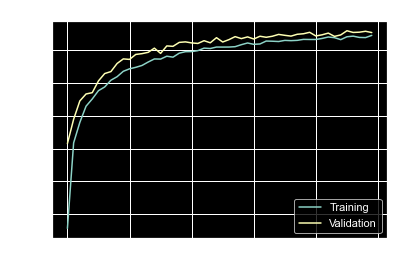

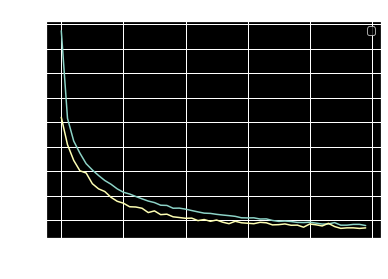

In [121]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

evaluate_model(history_CNN, X_test, utils.to_categorical(y_test, 5), model_CNN)

### GRU

In [141]:
# GRU model

model_GRU = Sequential()

model_GRU.add(layers.InputLayer(input_shape=(X_train.shape[1],1)))
model_GRU.add(layers.GRU(64, return_sequences=True, activation='relu'))
model_GRU.add(Dropout(0.25))
model_GRU.add(Flatten())
model_GRU.add(Dropout(0.5))
model_GRU.add(layers.Dense(5, activation='softmax'))

model_GRU.summary()


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 187, 64)           12864     
_________________________________________________________________
dropout_27 (Dropout)         (None, 187, 64)           0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 11968)             0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 11968)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 59845     
Total params: 72,709
Trainable params: 72,709
Non-trainable params: 0
_________________________________________________________________


In [142]:
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [143]:
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[reduceLR, earlystopping])

Epoch 1/20
625/625 [==============================] - 26s 41ms/step - loss: 0.7993 - accuracy: 0.7039 - val_loss: 0.5852 - val_accuracy: 0.7828 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 26s 41ms/step - loss: 0.5461 - accuracy: 0.8008 - val_loss: 0.4820 - val_accuracy: 0.8226 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 26s 42ms/step - loss: 0.4886 - accuracy: 0.8202 - val_loss: 0.4333 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 26s 42ms/step - loss: 0.4396 - accuracy: 0.8403 - val_loss: 0.4012 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 26s 41ms/step - loss: 0.4072 - accuracy: 0.8508 - val_loss: 0.3560 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 6/20
625/625 [==============================] - 26s 42ms/step - loss: 0.3868 - accuracy: 0.8587 - val_loss: 0.3679 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 7/20
625/625 [==============================] - 26s 

In [146]:
y_GRU_pred0 = model_GRU.predict(X_test)

y_GRU_pred = []
for i in range(y_GRU_pred0.shape[0]):
    y_GRU_pred.append(y_GRU_pred0[i].argmax())

0.9009227114927828
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     18118
         1.0       0.33      0.82      0.47       556
         2.0       0.77      0.93      0.84      1448
         3.0       0.21      0.93      0.34       162
         4.0       0.91      0.98      0.94      1608

    accuracy                           0.90     21892
   macro avg       0.64      0.91      0.71     21892
weighted avg       0.95      0.90      0.92     21892

Accuracy: 90.09%


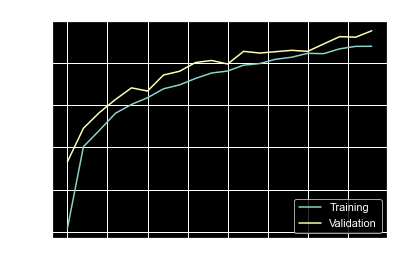

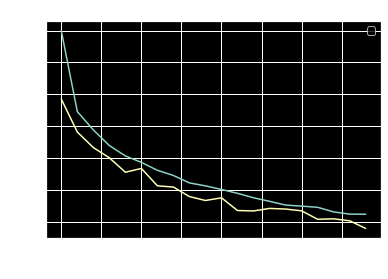

None


In [147]:
print(accuracy_score(y_test, y_GRU_pred))
print(classification_report(y_test, y_GRU_pred))
print(evaluate_model(history_GRU, X_test, utils.to_categorical(y_test, 5), model_GRU))

### alexNet

In [148]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPool1D, GlobalAveragePooling1D

In [154]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(187,1)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(5, activation='sigmoid'))

In [155]:
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

alexNet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [156]:
alexNet_history = alexNet_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[reduceLR, earlystopping])

Epoch 1/30
313/313 [==============================] - 15s 49ms/step - loss: 0.5540 - accuracy: 0.8055 - val_loss: 4.5275 - val_accuracy: 0.2044 - lr: 0.0010
Epoch 2/30
313/313 [==============================] - 16s 50ms/step - loss: 0.3049 - accuracy: 0.8959 - val_loss: 0.2628 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 3/30
313/313 [==============================] - 17s 54ms/step - loss: 0.2371 - accuracy: 0.9164 - val_loss: 0.1997 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 4/30
313/313 [==============================] - 17s 53ms/step - loss: 0.1930 - accuracy: 0.9329 - val_loss: 0.2152 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 5/30
313/313 [==============================] - 15s 49ms/step - loss: 0.1652 - accuracy: 0.9430 - val_loss: 0.2728 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 6/30
313/313 [==============================] - 15s 47ms/step - loss: 0.1319 - accuracy: 0.9554 - val_loss: 0.1729 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 7/30
313/313 [==============================] - 14s 

In [157]:
y_alex_pred0 = alexNet_model.predict(X_test)

0.9293805956513795
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     18118
         1.0       0.33      0.91      0.49       556
         2.0       0.87      0.96      0.91      1448
         3.0       0.44      0.89      0.59       162
         4.0       0.95      0.99      0.97      1608

    accuracy                           0.93     21892
   macro avg       0.72      0.93      0.78     21892
weighted avg       0.96      0.93      0.94     21892

Accuracy: 92.94%


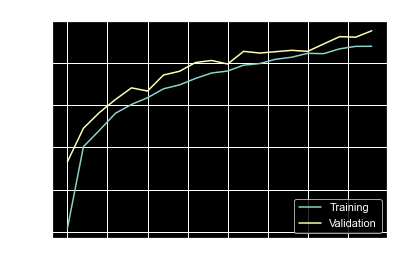

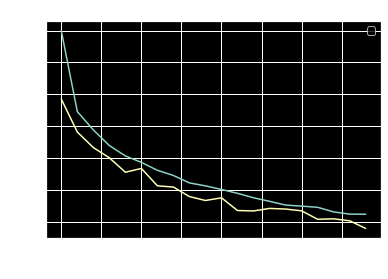

None


In [158]:
y_alex_pred = []
for i in range(y_alex_pred0.shape[0]):
    y_alex_pred.append(y_alex_pred0[i].argmax())
print(accuracy_score(y_test, y_alex_pred))
print(classification_report(y_test, y_alex_pred))
print(evaluate_model(history_GRU, X_test, utils.to_categorical(y_test, 5), alexNet_model))